In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

from dbmsbenchmarker import parameter, inspector

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline

In [2]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"

In [3]:
def get_workload(code):
    with open(path+"/"+code+"/queries.config",'r') as inp:
        workload_properties = ast.literal_eval(inp.read())
        return workload_properties

def map_index_to_queryname(numQuery):
    global query_properties
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery

def get_df_benchmarking(evaluate):
    global query_properties
    #evaluate = inspector.inspector(path)
    #evaluate.load_experiment(code=code, silent=True)
    query_properties = evaluate.get_experiment_query_properties()
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        #print(df)
        num_of_queries = len(df.index)
    #print("\n### Power@Size ((3600*SF)/(geo times))")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    #df.columns = ['Power@Size [~Q/h]']
    df_power = df.copy()
    #print(df.round(2))
    #print(parameter.defaultParameters['SF'])
    #print("\n### Geometric Mean of Medians of Timer Run [s]")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    #print(df.round(2))
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    #df_time = df.copy()
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        #df_time['SF'] = int(SF)
        #print(c)
        #print(connection.name)
        #print(connection.connection)
        df_time['orig_name'] = orig_name
        df_time['connection_name'] = connection_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    # aggregate per parallel pods per dbms - not valid for model=container?
    #benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    #benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    benchmark_start = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    #benchmark_count = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).count()
    benchmark_count = df_time.groupby(['connection_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    #df_benchmark['Throughput@Size [~GB/h]'] = (22*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF']).round(2)
    index_names = list(df_benchmark.index.names)
    #print(index_names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    #print(df_benchmark)
    #return df_benchmark
    #df.index = df.index.map(lambda x: str(x)[:-2])
    #print(evaluate.e.benchmarker.code, df.index.duplicated())
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    #df = df.sort_values('orig_name')
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    return df

def get_performance_single(evaluation):
    df = get_df_benchmarking(evaluation)
    #print(df)
    df = df.sort_values(['experiment_run', 'client'])
    return df

def get_performance(evaluation):
    df = get_df_benchmarking(evaluation)
    df = df.sort_values(['experiment_run', 'client'])
    result = df.groupby('client').agg({
        'Throughput@Size': 'sum',
        #'num_errors': 'sum',
        #'Latency Distribution.Average Latency (microseconds)': 'mean'
    }).reset_index()
    return result

def get_performance_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.base(code=code, path=path)
        workload = get_workload(code)
        df = get_performance(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_performance_all_single(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = inspector.inspector(path)
        evaluation.load_experiment(code=code, silent=True)
        #evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_performance_single(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def get_loading_time_max(evaluation):
    with open(path+"/"+evaluation.code+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
        pretty_connections = json.dumps(connections, indent=2)
        #print(pretty_connections)
        connections_sorted = sorted(connections, key=lambda c: c['name'])
        result = dict()
        for c in connections_sorted:
            result[c['name']] = {
                'time_load': c['timeLoad'],
                'time_ingest': c['timeIngesting'],
                'time_check': c['timeIndex'],
                #'terminals': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS'],
                #'target': c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TARGET'],
                'pods': c['parameter']['parallelism'],
                'tenant': c['parameter']['TENANT'] if 'TENANT' in c['parameter'] else '',
                'client': c['parameter']['client'],
                'datadisk': c['hostsystem']['datadisk'],
            }
            #result[c['parameter']['connection_parameter']['loading_parameters']['BENCHBASE_TERMINALS']] = c['timeIngesting']
        df = pd.DataFrame(result).T
        return df#df['time_load'].max()

def get_loading_time_max_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_loading_time_max(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance

def show_summary_monitoring_table(evaluate, component):
    df_monitoring = list()
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util_s', component=component)
    df = df.max().sort_index() - df.min().sort_index() # compute difference of counter
    #df = df.T.max().sort_index() - df.T.min().sort_index() # compute difference of counter
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["CPU [CPUs]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_util', component=component)
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max CPU"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df).round(2)
    df_cleaned.columns = ["Max RAM [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    ##########
    df = evaluate.get_monitoring_metric(metric='total_cpu_memory_cached', component=component)/1024
    #df = evaluate.get_loading_metrics('total_cpu_memory_cached')/1024
    df = df.max().sort_index()
    df_cleaned = pd.DataFrame(df)
    df_cleaned.columns = ["Max RAM Cached [Gb]"]
    if not df_cleaned.empty:
        df_monitoring.append(df_cleaned.copy())
    return df_monitoring

def get_monitoring_stream_single(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        return df

def get_monitoring_stream(evaluation):
    df_monitoring = show_summary_monitoring_table(evaluation, "stream")
    if len(df_monitoring) > 0:
        #print("\n### Stream SUT")
        df = pd.concat(df_monitoring, axis=1).round(2)
        df = df.reindex(index=evaluators.natural_sort(df.index))
        # If your DataFrame is named df and the index is a string like 'PostgreSQL-1-1-1024-0-1'
        df = df.copy()  # avoid modifying original
        df['client'] = df.index.str.rsplit('-', n=1).str[-1]
        #print(df)
        result = df.groupby('client').agg({
            'CPU [CPUs]': 'sum',
            'Max RAM [Gb]': 'sum',
            'Max RAM Cached [Gb]': 'sum',
            'Max CPU': 'sum',
        }).reset_index()
        return result

def get_monitoring_stream_all(codes):
    df_performance = pd.DataFrame()
    for code in codes:
        evaluation = evaluators.benchbase(code=code, path=path)
        workload = get_workload(code)
        df = get_monitoring_stream(evaluation)
        df['type']=workload['tenant_per']
        df['num_tenants']=workload['num_tenants']
        #print(df)
        df_performance = pd.concat([df_performance, df])
    return df_performance


In [4]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X: center of bar
                height,                             # Y: top of bar
                f'{height:.1f}',                    # Text (1 decimal place)
                ha='center', va='bottom', fontsize=8
            )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpch_" + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()



# Container

In [5]:
codes = [
    # container
    '1750860691', #tenants=1
    '1750862759', #tenants=2
    '1750865137', #tenants=3
    '1750867875', #tenants=4
    '1750870795', #tenants=5
    '1750874081', #tenants 6
    '1750877615', #tenants=7
    '1750881535', #tenants=8
    '1750885773', #tenants=9
    '1750890605', #tenants=10
    
    # database
    '1750860068', #tenants=1
    '1750862031', #tenants=2
    '1750864344', #tenants=3
    '1750866970', #tenants=4
    '1750869887', #tenants=5
    '1750873072', #tenants=6
    '1750876552', #tenants=7
    '1750880303', #tenants=8
    '1750884409', #tenants=9
    '1750889051', #tenants=10
    
    #schema
    '1750859440', #tenants=1
    '1750861312', #tenants=2
    '1750863504', #tenants=3
    '1750866067', #tenants=4
    '1750868888', #tenants=5
    '1750871956', #tenants=6   
    '1750875370', #tenants=7
    '1750879076', #tenants=8
    '1750883132', #tenants=9
    '1750887555', #tenants=10
]

In [14]:
codes = ['1751049830', '1751042932', '1751036351', '1751030495', '1751024409', '1751018248', '1750948214', '1750944773', '1750943614', '1750942745', '1750941748', '1750938835', '1750890605', '1750889051', '1750887555', '1750885773', '1750884409', '1750883132', '1750881535', '1750880303', '1750879076', '1750877615', '1750876552', '1750875370', '1750874081', '1750873072', '1750871956', '1750870795', '1750869887']
codes

['1751049830',
 '1751042932',
 '1751036351',
 '1751030495',
 '1751024409',
 '1751018248',
 '1750948214',
 '1750944773',
 '1750943614',
 '1750942745',
 '1750941748',
 '1750938835',
 '1750890605',
 '1750889051',
 '1750887555',
 '1750885773',
 '1750884409',
 '1750883132',
 '1750881535',
 '1750880303',
 '1750879076',
 '1750877615',
 '1750876552',
 '1750875370',
 '1750874081',
 '1750873072',
 '1750871956',
 '1750870795',
 '1750869887']

In [15]:
df_performance = get_performance_all_single(codes)
df_performance

,total_timer_execution,Power@Size [~Q/h],Geo Times [s],SF,experiment_run,client,time [s],count,Throughput@Size,type,num_tenants
DBMS,,,,,,,,,,,
PostgreSQL-BHT-1-0-1-1,5.581958,6.449350e+03,5.581958,10.0,1,1,1931,1,410.15,container,2
PostgreSQL-BHT-1-1-1-1,5.725308,6.287872e+03,5.725308,10.0,1,1,1961,1,403.88,container,2
PostgreSQL-BHT-1-0-2-1,5.600174,6.428372e+03,5.600174,10.0,1,2,1928,1,410.79,container,2
PostgreSQL-BHT-1-1-2-1,5.662387,6.357743e+03,5.662387,10.0,1,2,1935,1,409.30,container,2
PostgreSQL-BHT-2-1-1,5.805220,6.201316e+03,5.805220,10.0,1,1,1980,1,400.00,database,2
PostgreSQL-BHT-2-1-2,5.859996,6.143349e+03,5.859996,10.0,1,1,1995,1,396.99,database,2
PostgreSQL-BHT-2-2-1,5.786509,6.221367e+03,5.786509,10.0,1,2,1967,1,402.64,database,2
PostgreSQL-BHT-2-2-2,5.816515,6.189273e+03,5.816515,10.0,1,2,1983,1,399.39,database,2
PostgreSQL-BHT-2-1-1,5.804136,6.202473e+03,5.804136,10.0,1,1,1999,1,396.20,schema,2


In [16]:
df_multi = df_performance.set_index(['num_tenants', 'type'])
df_multi

total_timer_execution  Power@Size [~Q/h]  \
num_tenants type                                                  
2           container               5.581958       6.449350e+03   
            container               5.725308       6.287872e+03   
            container               5.600174       6.428372e+03   
            container               5.662387       6.357743e+03   
            database                5.805220       6.201316e+03   
            database                5.859996       6.143349e+03   
            database                5.786509       6.221367e+03   
            database                5.816515       6.189273e+03   
            schema                  5.804136       6.202473e+03   
            schema                  5.799652       6.207269e+03   
            schema                  5.818923       6.186712e+03   
            schema                  5.805793       6.200704e+03   
1           container               5.578556       6.453283e+03   
            container               5.625816       6.399072e+03   
            database                5.782133       6.226077e+03   
            database                5.740931       6.270760e+03   
            schema                  5.737534       6.274472e+03   
            schema                  5.772405       6.236569e+03   
2           schema                  0.922773       3.901286e+03   
            schema                  0.916256       3.929031e+03   
            schema                  0.912312       3.946019e+03   
            schema                  0.920733       3.909929e+03   
            schema                  0.601105       5.988975e+03   
            schema                  0.594765       6.052815e+03   
            schema                  0.606394       5.936737e+03   
            schema                  0.611930       5.883029e+03   
            schema                  0.615967       5.844472e+03   
            schema                  0.610916       5.892793e+03   
            schema                  0.597021       6.029941e+03   
            schema                  0.591368       6.087577e+03   
            schema                  0.001755       2.050989e+06   
            schema                  0.001755       2.051151e+06   
            schema                  0.001365       2.636484e+06   
            schema                  0.001655       2.174803e+06   
            schema                  0.001847       1.948621e+06   
            schema                  0.001815       1.983454e+06   
            schema                  0.001485       2.424256e+06   
            schema                  0.001721       2.091549e+06   
1           schema                  0.852467       4.223037e+03   
            schema                  0.851021       4.230211e+03   
10          container               1.041314       3.457169e+03   
            container               1.031390       3.490435e+03   
            container               1.038954       3.465022e+03   
            container               1.055140       3.411871e+03   
            container               1.027420       3.503921e+03   
            container               1.040644       3.459396e+03   
            container               1.031790       3.489082e+03   
            container               1.049803       3.429214e+03   
            container               1.032494       3.486703e+03   
            container               1.032019       3.488309e+03   
            container               1.033418       3.483587e+03   
            container               1.057240       3.405093e+03   
            container               1.051696       3.423042e+03   
            container               1.063725       3.384333e+03   
            container               1.053831       3.416108e+03   
            container               1.043389       3.450294e+03   
            container               1.034135       3.481169e+03   
            container               1.025517       3.510423e+03   
   

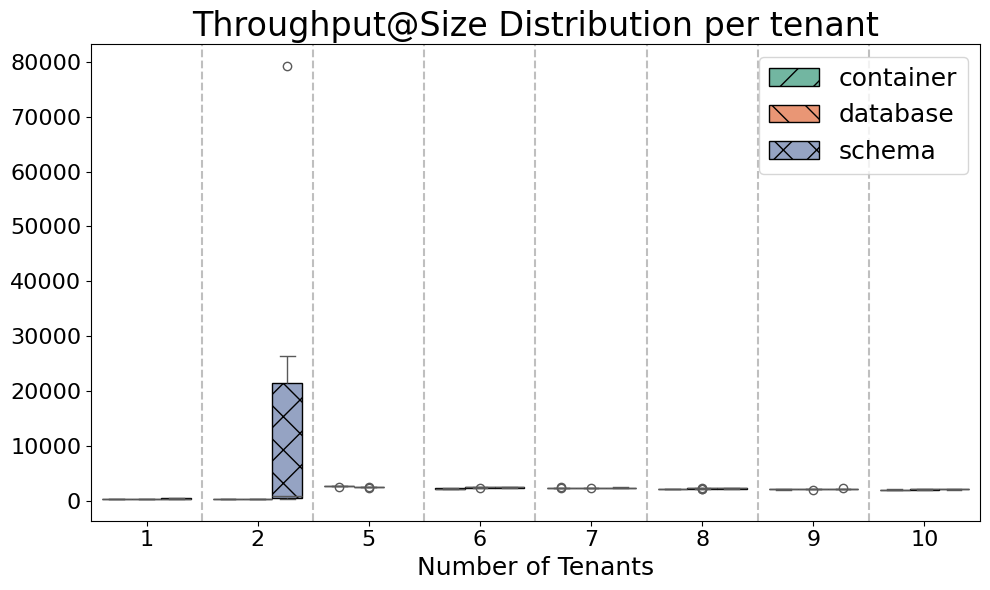

In [17]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Throughput@Size',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = "Throughput@Size Distribution per tenant"
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

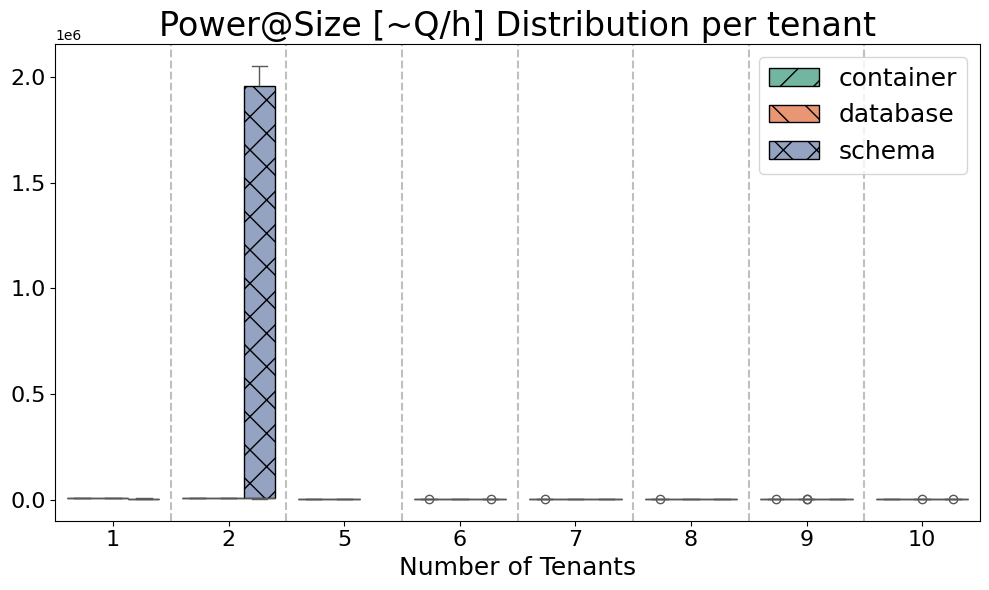

In [18]:
df = df_performance[df_performance['client']==1]
#df = df_performance.copy()
#print(df)
plt.figure(figsize=(10, 6))
# Hatch styles for each type
hatch_map = {
    'container': '/',
    'database': '\\',
    'schema': 'x'
}
hue_order = ['container', 'database', 'schema']

# Plot boxplots grouped by num_tenants and colored by type
ax = sns.boxplot(
    data=df,
    x='num_tenants',
    y='Power@Size [~Q/h]',
    hue='type',
    palette='Set2'  # consistent colors per type
)

# Add vertical separator lines between groups
# Get the number of unique num_tenants and type
num_groups = df['num_tenants'].nunique()
num_types = df['type'].nunique()

# Extract hue order
hue_order = ax.get_legend_handles_labels()[1]
num_hue = len(hue_order)

# Get hue order from seaborn (types)
_, type_order = ax.get_legend_handles_labels()
num_types = len(type_order)

#print(len(ax.patches))
# Set hatches correctly: patches are grouped by x then by hue
for i, patch in enumerate(ax.patches):
    #print(i)
    type_index = i // (num_groups)
    if type_index >= num_types:
        break
    type_name = type_order[type_index]
    patch.set_hatch(hatch_map.get(type_name, ''))
    #print(hatch_map.get(type_name, ''))
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Each num_tenants group has num_types boxes
for i in range(1, num_groups):
    xpos = i - 0.5 #0.5
    ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)


# Update legend with matching hatches
handles, labels = ax.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    hatch = hatch_map.get(label, '')
    handle.set_hatch(hatch)
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

title = 'Power@Size [~Q/h] Distribution per tenant'
plt.title(title, fontsize=24)
plt.xlabel("Number of Tenants")
plt.ylabel("")#"Goodput (requests/second)")
plt.xlabel("Number of Tenants", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
plt.legend(title="Type")
ax.legend(fontsize=18)
plt.tight_layout()
filename = "tpch_" + sanitize_filename(title) + ".png"    
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

In [19]:
df_performance = get_performance_all(codes)
df_performance

,client,Throughput@Size,type,num_tenants
0,1,814.03,container,2
1,2,820.09,container,2
0,1,796.99,database,2
1,2,802.03,database,2
0,1,795.39,schema,2
1,2,795.78,schema,2
0,1,416.84,container,1
1,2,412.29,container,1
0,1,400.00,database,1
1,2,402.64,database,1


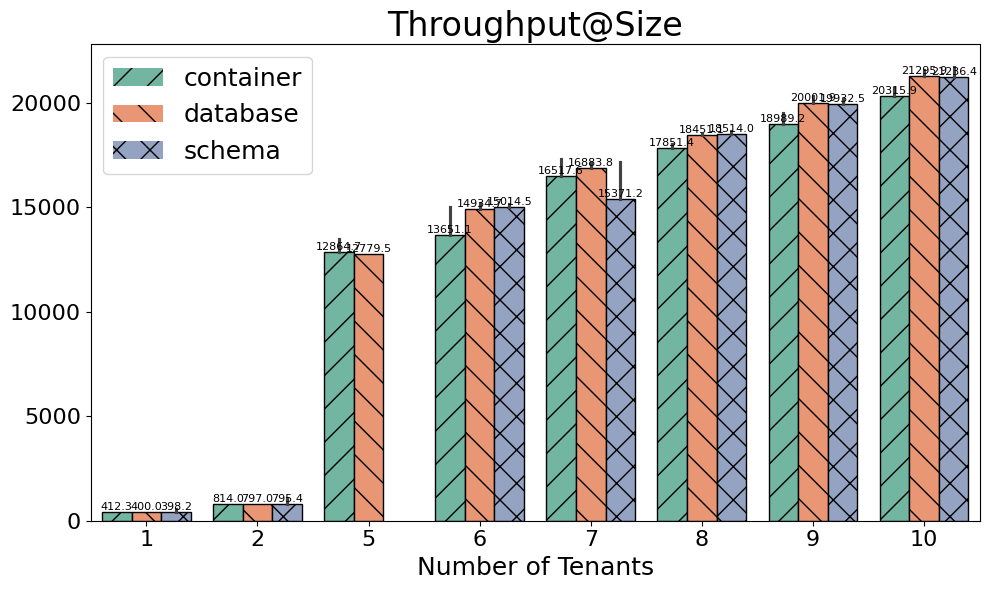

In [20]:
plot_bars(df_performance, y='Throughput@Size', title='Throughput@Size', estimator='min')

In [33]:
df_performance = get_loading_time_max_all(codes)
df_performance

,time_load,time_ingest,time_check,pods,tenant,client,datadisk,type,num_tenants
PostgreSQL-BHT-1-0-1-1,315.0,104.0,209.0,1,0,1,2757,container,1
PostgreSQL-BHT-1-0-2-1,315.0,104.0,209.0,1,0,2,2757,container,1
PostgreSQL-BHT-1-0-1-1,325.0,105.0,216.0,1,0,1,2757,container,2
PostgreSQL-BHT-1-0-2-1,325.0,105.0,216.0,1,0,2,2757,container,2
PostgreSQL-BHT-1-1-1-1,327.0,107.0,217.0,1,1,1,2757,container,2
PostgreSQL-BHT-1-1-2-1,327.0,107.0,217.0,1,1,2,2757,container,2
PostgreSQL-BHT-1-0-1-1,312.0,89.0,216.0,1,0,1,2757,container,3
PostgreSQL-BHT-1-0-2-1,312.0,89.0,216.0,1,0,2,2757,container,3
PostgreSQL-BHT-1-1-1-1,311.0,89.0,216.0,1,1,1,2757,container,3
PostgreSQL-BHT-1-1-2-1,311.0,89.0,216.0,1,1,2,2757,container,3


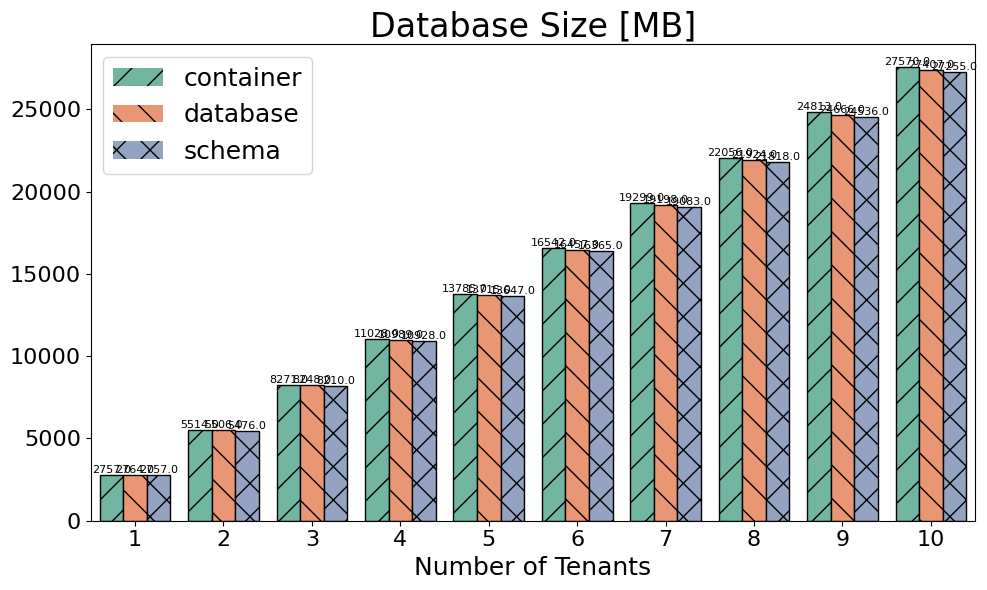

In [34]:
df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk']

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts

plot_bars(df, y='datadisk_normalized', title='Database Size [MB]', estimator='sum')

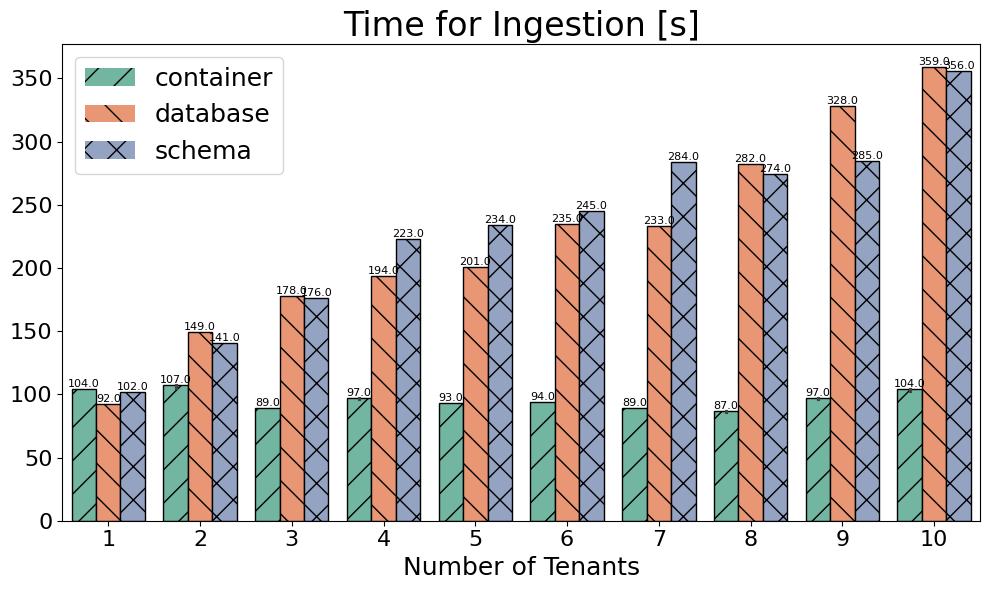

In [14]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

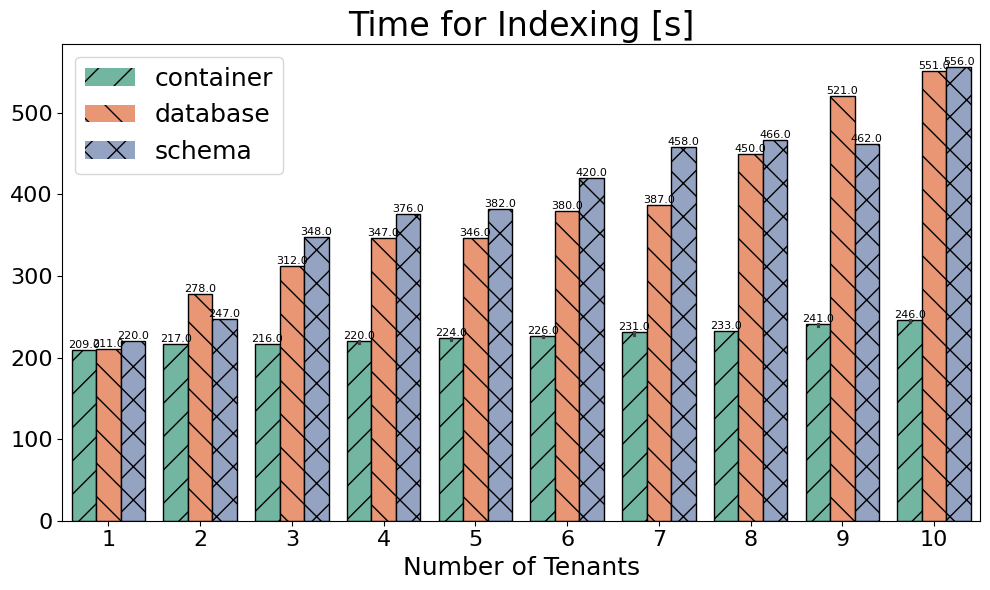

In [15]:
plot_bars(df_performance, y='time_check', title='Time for Indexing [s]', estimator='max')

In [16]:
df_performance = get_monitoring_stream_all(codes)
df_performance = df_performance[df_performance['client'] == '1']
df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,type,num_tenants
0,1,88.96,3.75,5.38,1.60,container,1
0,1,162.57,11.00,14.24,0.00,container,2
0,1,149.85,11.13,16.00,2.64,container,3
0,1,274.91,15.08,21.56,2.33,container,4
0,1,590.60,19.05,27.15,6.52,container,5
0,1,580.74,22.68,32.62,3.55,container,6
0,1,901.66,26.67,38.01,4.53,container,7
0,1,1021.32,30.26,43.24,8.40,container,8
0,1,1371.40,34.35,48.93,5.59,container,9
0,1,1464.75,38.03,54.23,8.32,container,10


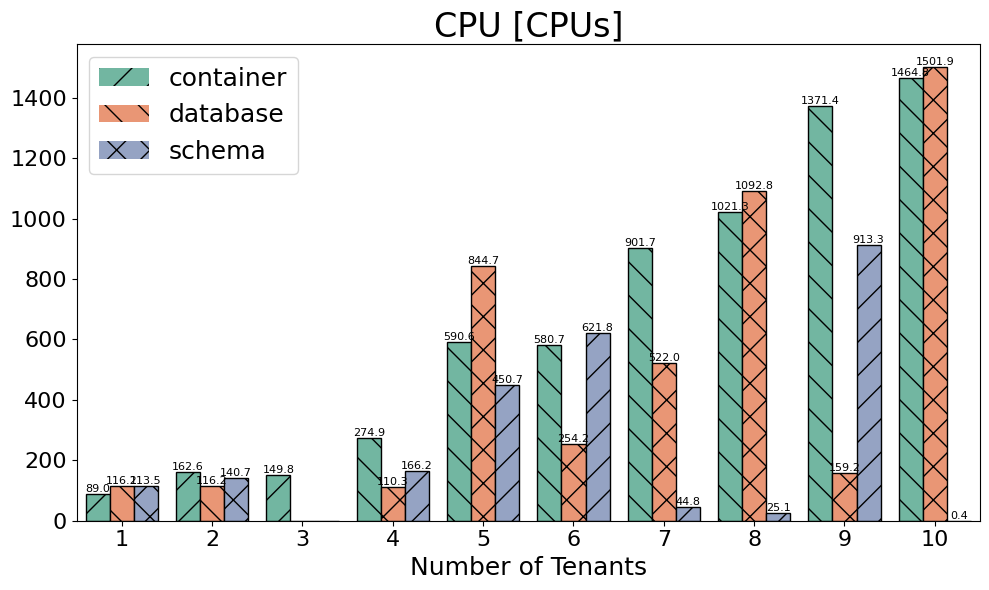

In [17]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

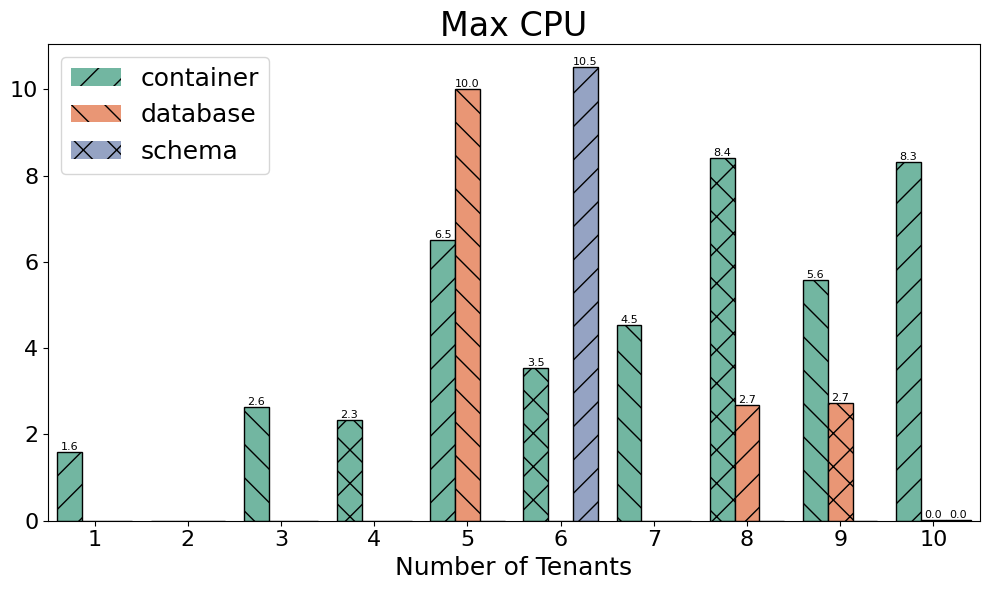

In [18]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

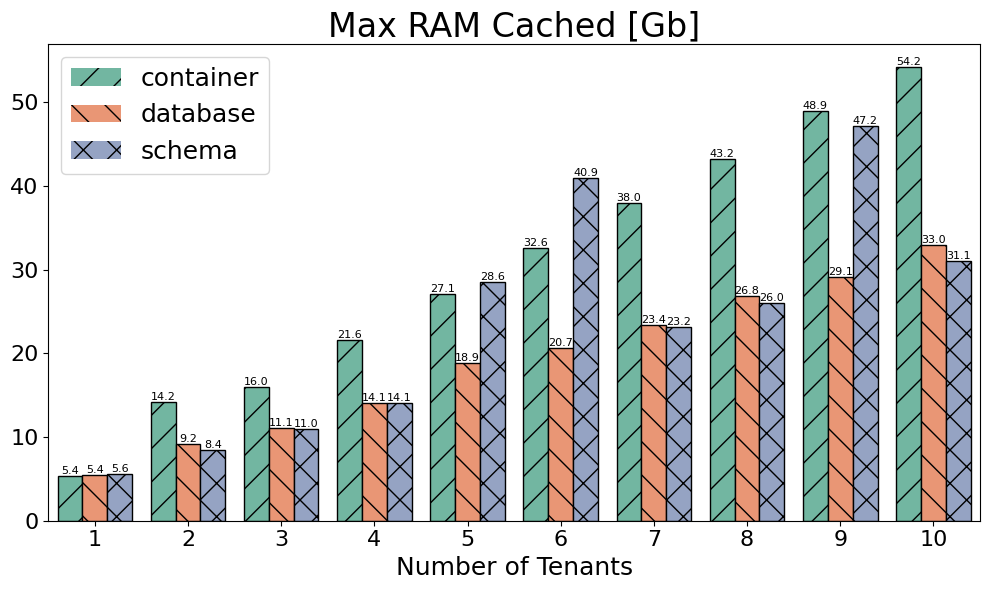

In [19]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

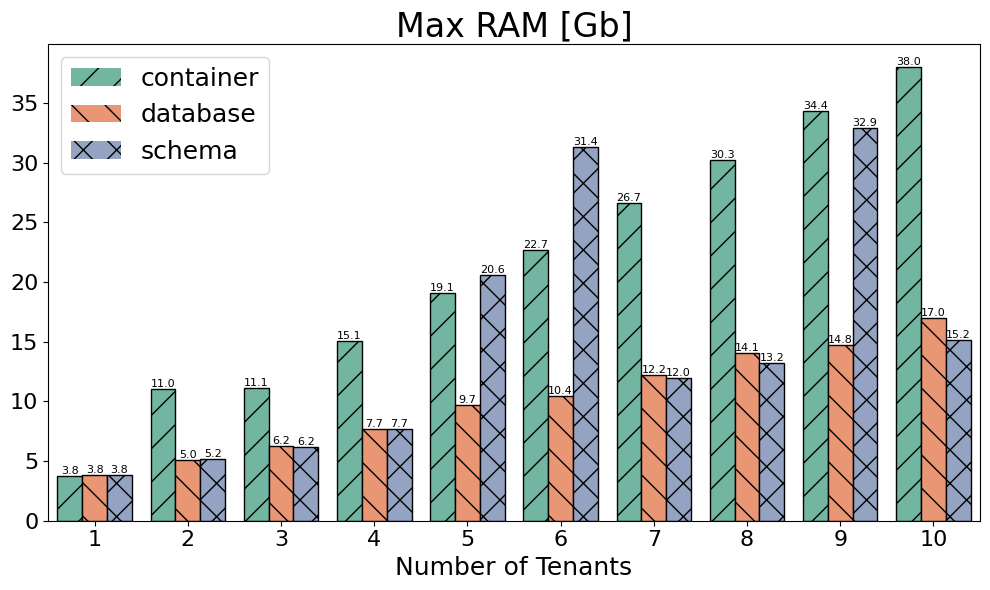

In [20]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

# Single Experiment

In [ ]:
code = '1750741356'
evaluation = evaluators.benchbase(code=code, path=path)
workload = get_workload(code)

In [ ]:
df=get_performance_single(evaluation)
df['type']=workload['tenant_per']
df['num_tenants']=workload['num_tenants']
df.T

In [ ]:
get_loading_time_max(evaluation)

In [ ]:
get_monitoring_stream_single(evaluation).sort_values('client')

In [ ]:
get_monitoring_stream(evaluation)

In [ ]:
code=codes[9]
evaluate = inspector.inspector(path)
evaluate.load_experiment(code=code, silent=True)
query_properties = evaluate.get_experiment_query_properties()
query_properties

In [ ]:
print("\n### Power@Size ((3600*SF)/(geo times))")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index().astype('float')
df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
#df.columns = ['Power@Size [~Q/h]']
df_power = df.copy()
print(df.round(2))
print(parameter.defaultParameters['SF'])

In [ ]:
print("\n### Geometric Mean of Medians of Timer Run [s]")
df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
df = (df/1000.0).sort_index()
df.columns = ['Geo Times [s]']
df_geo_mean_runtime = df.copy()
print(df.round(2))


In [ ]:
df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
df

In [ ]:
#df_time = df.copy()
df_merged_time = pd.DataFrame()
for connection_nr, connection in evaluate.benchmarks.dbms.items():
    df_time = pd.DataFrame()
    c = connection.connectiondata
    connection_name = c['name']
    orig_name = c['orig_name']
    #print(orig_name)
    eva = evaluate.get_experiment_connection_properties(c['name'])
    df_time.index = [connection_name]
    #df_time['SF'] = int(SF)
    #print(c)
    #print(connection.name)
    #print(connection.connection)
    df_time['orig_name'] = orig_name
    df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
    df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
    #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
    df_time['num_experiment'] = int(c['parameter']['numExperiment'])
    df_time['num_client'] = int(c['parameter']['client'])
    df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
    df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
    df_time['benchmark_total_time'] = df_time['benchmark_end'] - df_time['benchmark_start']
    #print(df_time)
    df_merged_time = pd.concat([df_merged_time, df_time])

df_merged_time#.sort_values('orig_name')

In [ ]:
df = pd.concat([df, df_merged_time], axis=1)
df = df.sort_values('orig_name')
df

In [ ]:
df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
df

In [ ]:
def map_index_to_queryname(numQuery):
    if numQuery[1:] in query_properties and 'config' in query_properties[numQuery[1:]] and 'title' in query_properties[numQuery[1:]]['config']:
        return query_properties[numQuery[1:]]['config']['title']
    else:
        return numQuery

def get_benchmark_df():
    code=codes[9]
    evaluate = inspector.inspector(path)
    evaluate.load_experiment(code=code, silent=True)
    query_properties = evaluate.get_experiment_query_properties()
    #print(query_properties)
    print(evaluate.e)#['connectionmanagement']['numRun'])
    num_of_queries = 0
    df = evaluate.get_aggregated_query_statistics(type='latency', name='execution', query_aggregate='Mean')
    if not df is None:
        df = df.sort_index().T.round(2)
        df.index = df.index.map(map_index_to_queryname)
        #print(df)
        num_of_queries = len(df.index)
    #print("\n### Power@Size ((3600*SF)/(geo times))")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='execution', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index().astype('float')
    df['Power@Size [~Q/h]'] = float(parameter.defaultParameters['SF'])*3600./df
    #df.columns = ['Power@Size [~Q/h]']
    df_power = df.copy()
    #print(df.round(2))
    #print(parameter.defaultParameters['SF'])
    #print("\n### Geometric Mean of Medians of Timer Run [s]")
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df = (df/1000.0).sort_index()
    df.columns = ['Geo Times [s]']
    df_geo_mean_runtime = df.copy()
    #print(df.round(2))
    df = pd.concat([df_power, df_geo_mean_runtime], axis=1)
    #df_time = df.copy()
    df_merged_time = pd.DataFrame()
    for connection_nr, connection in evaluate.benchmarks.dbms.items():
        df_time = pd.DataFrame()
        c = connection.connectiondata
        connection_name = c['name']
        orig_name = c['orig_name']
        eva = evaluate.get_experiment_connection_properties(c['name'])
        df_time.index = [connection_name]
        #df_time['SF'] = int(SF)
        #print(c)
        #print(connection.name)
        #print(connection.connection)
        df_time['orig_name'] = orig_name
        df_time['SF'] = float(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_merged_time = pd.concat([df_merged_time, df_time])
    df_time = df_merged_time.sort_index()
    benchmark_start = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).min('benchmark_start')
    benchmark_end = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).max('benchmark_end')
    df_benchmark = pd.DataFrame(benchmark_end['benchmark_end'] - benchmark_start['benchmark_start'])
    df_benchmark.columns = ['time [s]']
    benchmark_count = df_time.groupby(['orig_name', 'SF', 'num_experiment', 'num_client']).count()
    df_benchmark['count'] = benchmark_count['benchmark_end']
    df_benchmark['SF2'] = df_benchmark.index.map(lambda x: x[1])
    df_benchmark['Throughput@Size'] = (num_of_queries*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF2']).round(2)
    #df_benchmark['Throughput@Size [~GB/h]'] = (22*3600.*df_benchmark['count']/df_benchmark['time [s]']*df_benchmark['SF']).round(2)
    index_names = list(df_benchmark.index.names)
    #print(index_names)
    index_names[0] = "DBMS"
    df_benchmark.rename_axis(index_names, inplace=True)
    df_benchmark = df_benchmark.reset_index(level=['SF', 'num_experiment', 'num_client'])
    #print(df_benchmark)
    #return df_benchmark
    df.index = df.index.map(lambda x: str(x)[:-2])
    df = pd.concat([df, df_benchmark], axis=1)
    df.drop('SF2', axis=1, inplace=True)
    df.rename(columns={'num_experiment': 'experiment_run'}, inplace=True)
    df.rename(columns={'num_client': 'client'}, inplace=True)
    #df = df.sort_values('orig_name')
    df['Power@Size [~Q/h]'] = df['SF']*3600./df['total_timer_execution']
    return df

In [ ]:
get_benchmark_df()